In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import gudhi as gd
from LISM import pipeline
from difftda import SimplexTreeModel_ISM
from pyvis import network as net
import networkx as nx
from helpers import plot_optim
import tensorflow as tf
from helpers import connected_geometric_network, plotly_geometric_network

## Load data

In [3]:
with open('activation_data_mnist/simplexTree.pickle', 'rb') as handle:
    simplex_list = pickle.load(handle)

ST = gd.SimplexTree()
initial_value = -1e10

for simplex in simplex_list:
    ST.insert(simplex, initial_value)


In [4]:
stbase = gd.SimplexTree()
for i in range(len(simplex_list)):
    stbase.insert(np.array(simplex_list[i]), -1e10)
f = open('data/adv_simplextree.txt', 'w')
for (s,_) in stbase.get_filtration():
    for v in s:
        f.write(str(v) + " ")
    f.write('\n')
f.close()

convention label : 0 normal, 1 fgsm, 2 fgsm noise, 3 cw, 4 cw noise

In [5]:
fgsm = np.load('activation_data_mnist/fgsm.npy')
fgsm_noise = np.load('activation_data_mnist/fgsm_noise.npy')
normal = np.load('activation_data_mnist/normal.npy')
cw = np.load('activation_data_mnist/cw.npy')
cw_noise = np.load('activation_data_mnist/cw_noise.npy')

## Visualizing the neural network

We visualize a sub-graph $G$ of the neural network $\bar{G}$ formed by the $1$-dimensional simplicial complex. More precisely, we discard from $\bar{G}$ any node that is not part of a simple path going from the first layer to the last layer. Here, we have $|\bar{G}|=260$ and $|G|=49$. Altough $G$ represents the underlying function of the neural network, $\bar{G}$ encodes the connected components behavior of the initial graph, and thus its $0$-dimensional homology.

In [6]:
layers = np.array(fgsm[0][:,3], dtype=int)

G = connected_geometric_network(simplex_list, layers)

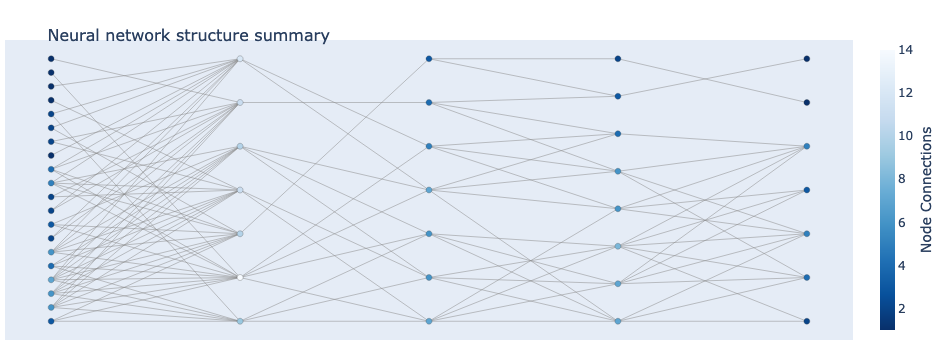

In [7]:
plotly_geometric_network(G)

## Compute distance matrix with possible data leakage

We compute the distance matrix $D=(d_{ij})_{i,j=1}^N$ where $d_{ij}$ is the linear integral sheaf distance between inputs $i$ and $j$.

In [8]:
n_inputs = 20
features = [0,1]
data = np.zeros((n_inputs * 5, 260, 2))
labels = []
for i in range(5):
    labels += [i]*n_inputs


In [9]:
data[0:n_inputs, : ,: ] = fgsm[0:n_inputs, : , features ]
data[n_inputs:2*n_inputs, : ,: ] = fgsm_noise[0:n_inputs, : , features ]
data[2*n_inputs:3*n_inputs, : ,: ] = normal[0:n_inputs, : , features ]
data[3*n_inputs:4*n_inputs, : ,: ] = cw[0:n_inputs, : , features ]
data[4*n_inputs:5*n_inputs, : ,: ] = cw_noise[0:n_inputs, : , features ]


In [10]:
print("We look at an initial graph of {} nodes, and {} different {}-filtrations on this graph.".format(data.shape[1], data.shape[0], data.shape[2]))

We look at an initial graph of 260 nodes, and 100 different 2-filtrations on this graph.


### Compute a single distance for debugging 

In [11]:
theta = np.random.rand()*np.pi/2
p_ = np.array([np.cos(theta), np.sin(theta)], dtype=np.float32).reshape(2,1)
p = tf.Variable(initial_value=p_, trainable=True, dtype = tf.float32)

m1 = tf.Variable(initial_value=data[0], trainable=False, dtype=tf.float32)
m2 = tf.Variable(initial_value=data[1], trainable=False, dtype=tf.float32)

model = SimplexTreeModel_ISM(p, m1, m2, stbase = "data/adv_simplextree.txt", dim=0, card=260)

dgm1, dgm2 = model.call()

## Running the various pipelines

### Distance matrix for the adversarial attack experiment

In [11]:
meta_data = (data[:3], "data/adv_simplextree.txt")

pipe = pipeline(0, meta_data, 260, dims=[0])

In [12]:
D0 = pipe.distance_matrix(dim=0)

  0%|          | 0/3 [00:00<?, ?it/s]2022-05-27 00:32:43.955959: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-27 00:32:44.017920: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ffbbff69010 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-27 00:32:44.017943: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
100%|██████████| 3/3 [00:14<00:00,  4.75s/it]


### Visualization of optimization for single distance computation

In [17]:
meta_data = (data[:4], "data/adv_simplextree.txt")

pipe = pipeline(0, meta_data, 260, dims=[0])

In [18]:
opt = pipe.single_distance(0)

Please enter data consisting of only two multi-filtrations. None is returned.


In [16]:
plot_optim(opt, True)

### Distance matrix for the MNIST classification experiment